In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings("ignore")

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [3]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [7]:
pd.set_option('display.max_colwidth', None)
df = pd.read_csv("cleaned.csv")
df.head()

,Brand,Product_Description,Screen_Size,RAM,Processor,GPU,GPU_Type,Resolution,Condition,Price
0,Lenovo,Lenovo ThinkPad 14” HD Laptop PC Computer Core i5 16GB RAM 256GB SSD Windows 10,14.0,16,Intel Core i5 7th Gen.,Intel HD Graphics 520,Integrated/On-Board Graphics,NaN,Very Good - Refurbished,189.99
1,Dell,"Dell Latitude 15.6"" Laptop Intel Core i5 64GB RAM 2TB SSD Wi-Fi Windows 11 Pro",15.6,64,Intel Core i5 8th Gen.,Intel UHD Graphics 620,Integrated/On-Board Graphics,1920 x 1080,Very Good - Refurbished,349.99
2,HP,"NEW HP 15 Laptop. 15.6"" 1080p, i5-1135G7, 8GB RAM, 256GB SSD,Win 11 -15-dy2795wm",15.6,8,Intel Core i5 11th Gen.,Intel Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1080,New,369.95
3,Lenovo,2024 Lenovo Ideapad Laptop 15 FHD Touch Intel i5 Upto 40GB RAM&2TB SSD Win 11Pro,15.6,Up,Intel Core i5 11th Gen.,Intel Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1080,New,459.00
4,Lenovo,"2024 Lenovo Ideapad Laptop 15.6"" FHD Touch Intel i5 16GB RAM & 512GB Win 11 Pro",15.6,16,Intel Core i5 11th Gen.,Intel Iris Xe Graphics,Integrated/On-Board Graphics,1920 x 1080,New,499.00


## 1. Data Understanding

In [8]:
df.shape

(2952, 10)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand                2952 non-null   object 
 1   Product_Description  2952 non-null   object 
 2   Screen_Size          2952 non-null   float64
 3   RAM                  2952 non-null   object 
 4   Processor            2952 non-null   object 
 5   GPU                  2604 non-null   object 
 6   GPU_Type             2718 non-null   object 
 7   Resolution           2565 non-null   object 
 8   Condition            2952 non-null   object 
 9   Price                2952 non-null   float64
dtypes: float64(2), object(8)
memory usage: 230.8+ KB


In [10]:
df.describe()

,Screen_Size,Price
count,2952.000000,2952.000000
mean,14.550237,517.552805
std,1.175322,235.592872
min,10.000000,0.000000
25%,14.000000,325.990000
50%,14.000000,489.990000
75%,15.600000,699.000000
max,18.000000,999.990000


In [11]:
df.isnull().sum().sort_values(ascending=False)

,0
Resolution,387
GPU,348
GPU_Type,234
Brand,0
Product_Description,0
Screen_Size,0
RAM,0
Processor,0
Condition,0
Price,0


In [12]:
df.nunique()

,0
Brand,25
Product_Description,2952
Screen_Size,28
RAM,23
Processor,48
GPU,220
GPU_Type,8
Resolution,54
Condition,5
Price,1119


## 2. Data Preprocessing

In [13]:
dfp = df.copy()

In [14]:
cat_cols = dfp.select_dtypes(include='object').columns
cat_cols

Index(['Brand', 'Product_Description', 'RAM', 'Processor', 'GPU', 'GPU_Type',
       'Resolution', 'Condition'],
      dtype='object')

In [15]:
def unique_vals(col):
    print(f"Details of the column {col} is: \n {dfp[col].unique()}")
    print("-"*100)

In [16]:
for col in cat_cols:
    unique_vals(col)

Details of the column Brand is: 
 ['Lenovo' 'Dell' 'HP' 'Microsoft' 'Asus' 'Razer' 'MSI' 'Apple' 'Panasonic'
 'LG' 'Samsung' 'Acer' 'Gateway' 'Huawei' 'Getac' 'Google' 'Dell Inc.'
 'Chuwi' 'Sony' 'ByteSpeed' 'Eurocom' 'Gigabyte' 'AVITA' 'Intel' 'Ruggon']
----------------------------------------------------------------------------------------------------
Details of the column Product_Description is: 
 ['Lenovo ThinkPad 14” HD Laptop PC Computer Core i5 16GB RAM 256GB SSD Windows 10'
 'Dell Latitude 15.6" Laptop Intel Core i5 64GB RAM 2TB SSD Wi-Fi Windows 11 Pro'
 'NEW HP 15 Laptop. 15.6" 1080p, i5-1135G7, 8GB RAM, 256GB SSD,Win 11 -15-dy2795wm'
 ...
 'Dell Precision 5550 Workstation 15 15.6 Laptop Core i7 4k uhd Touchscreen F'
 'HP 15 Laptop 15.6" FHD i5-1135G7 8GB RAM 256GB SSD Win 11 -15-dy2795wm'
 '3 PCS Karlash 6 Column Undated Appointment Book – Six Person Daily and Hourly...']
----------------------------------------------------------------------------------------------------
Det

In [17]:
imputer = SimpleImputer(strategy='most_frequent').set_output(transform="pandas")
dfp[["Resolution","GPU_Type"]] = imputer.fit_transform(dfp[["Resolution","GPU_Type"]])

In [18]:
def extract_numbers(text):
    nums = re.findall(r'\d+(?:\.\d+)?', text)
    if nums:
        return int(nums[0])
    else:
        return None

In [23]:
import re

def extract_numbers(text):
    if isinstance(text, str):  # Check if the input is a string
        nums = re.findall(r'\d+(?:\.\d+)?', text)
        if nums:
            return int(nums[0])
    return None  # Return None if not a string or no numbers found

dfp["RAM"] = dfp["RAM"].map(extract_numbers) # Remove extra [] around "RAM"

In [24]:
dfp["GPU_Type"] = dfp["GPU_Type"].apply(lambda x: "Integrated/On-Board Graphics" if x != "Dedicated Graphics" else x)

In [25]:
dfp["Resolution"] = dfp["Resolution"].str.replace("5K","5120x2880")
dfp["Resolution"] = dfp["Resolution"].str.replace("FHD","1920x1080")
dfp["Resolution"] = dfp["Resolution"].str.replace("1080p","1920x1080")
resolution_df = dfp["Resolution"].str.split("x|X",n=1,expand=True)
dfp["Resolution_Width"] = resolution_df[0]
dfp["Resolution_Height"] = resolution_df[1]
dfp["Resolution_Width"] = dfp["Resolution_Width"].str.findall("\d{4}").apply(lambda x: int(x[0]) if len(x) != 0 else None)
dfp["Resolution_Height"] = dfp["Resolution_Height"].str.findall("\d.[0-9]*").apply(lambda x: None if x == None or x == [] else int(x[0]))

In [26]:
dfp["Processor"] = dfp["Processor"].apply(lambda x : " ".join(x.split(" ")[:3]))
dfp["Processor"].unique(), dfp["Processor"].nunique()

(array(['Intel Core i5', 'Intel Core i7', 'Intel Core i3', 'Intel Core i9',
        'AMD Ryzen 5', 'AMD Ryzen 9', 'AMD Ryzen 7', 'AMD Ryzen 3'],
       dtype=object),
 8)

In [27]:
def GPUPreprocess(text):
    """
    Preprocess text of GPU specification into more general term and clustered item.
    """
    text = str(text)
    text = text.lower()

    if re.search(r'intel hd', text):
        return 'Intel HD'
    elif re.search(r'intel iris', text):
        return 'Intel Iris'
    elif re.search(r'nvidia geforce|nvidia gtx', text):
        return 'NVIDIA GeForce'
    elif re.search(r'nvidia quadro|nvidia t1200', text):
        return 'NVIDIA Quadro'
    elif re.search(r'intel uhd', text):
        return 'Intel UHD'
    elif re.search(r'radeon', text):
        return 'AMD Radeon'
    elif 'intel' in text or 'i5-8250u' in text:
        return 'Other Intel'
    else:
        return 'Other GPU'

In [28]:
dfp["GPU"] = dfp["GPU"].apply(GPUPreprocess)

In [29]:
dfp["GPU"].unique()

array(['Intel HD', 'Intel UHD', 'Intel Iris', 'NVIDIA Quadro',
       'NVIDIA GeForce', 'Other GPU', 'AMD Radeon', 'Other Intel'],
      dtype=object)

In [30]:
def extract_storage(text):
    """
    Extract information about storage capacity from product description.
    """
    SSD_pattern = r"(\d+\.?\d*)\s*(TB|GB)\s*(SSD)"
    HDD_pattern = r"(\d+\.?\d*)\s*(TB|GB)\s*(HDD)"
    return re.findall(SSD_pattern, text), re.findall(HDD_pattern, text)

In [31]:
# Making of storage column from product description column
storage_df = dfp["Product_Description"].apply(extract_storage)
dfp["SSD"] = storage_df.apply(lambda x: " ".join(x[0][0]) if x[0] != [] else '0')
dfp["HDD"] = storage_df.apply(lambda x: " ".join(x[1][0]) if x[1] != [] else '0')
dfp["SSD"] = dfp["SSD"].str.replace("TB","000 GB").str.findall("\d").apply(lambda x: "".join(x)).astype("int64")
dfp["HDD"] = dfp["HDD"].str.replace("TB","000 GB").str.findall("\d").apply(lambda x: "".join(x)).astype("int64")
dfp["SSD"].unique(), dfp["HDD"].unique()

(array([  256,  2000,     0,   512,  1000,   238,   128,   240,    16,
           64,   120,   255,   500,   250,   480,   800,   180,  4000,
        15000,     4]),
 array([   0, 1000,  256,  500,  512, 2000]))

In [32]:
dfp.loc[(dfp["SSD"] == 15000)]

,Brand,Product_Description,Screen_Size,RAM,Processor,GPU,GPU_Type,Resolution,Condition,Price,Resolution_Width,Resolution_Height,SSD,HDD
1594,Asus,"ASUS Vivobook 15.6"" Touchscreen Intel 11th Gen i3 8GB 256G X515EA-212.V15TB SSD",15.6,None,Intel Core i3,Intel HD,Integrated/On-Board Graphics,1920 x 1080,New,375.0,1920.0,1080.0,15000,0


In [33]:
dfp["SSD"] = dfp["SSD"].replace(15000,256)

In [34]:
dfp.isnull().sum()

,0
Brand,0
Product_Description,0
Screen_Size,0
RAM,2952
Processor,0
GPU,0
GPU_Type,0
Resolution,0
Condition,0
Price,0


In [35]:
dfp.loc[dfp["RAM"].isnull()]

,Brand,Product_Description,Screen_Size,RAM,Processor,GPU,GPU_Type,Resolution,Condition,Price,Resolution_Width,Resolution_Height,SSD,HDD
0,Lenovo,Lenovo ThinkPad 14” HD Laptop PC Computer Core i5 16GB RAM 256GB SSD Windows 10,14.0,None,Intel Core i5,Intel HD,Integrated/On-Board Graphics,1920 x 1080,Very Good - Refurbished,189.99,1920.0,1080.0,256,0
1,Dell,"Dell Latitude 15.6"" Laptop Intel Core i5 64GB RAM 2TB SSD Wi-Fi Windows 11 Pro",15.6,None,Intel Core i5,Intel UHD,Integrated/On-Board Graphics,1920 x 1080,Very Good - Refurbished,349.99,1920.0,1080.0,2000,0
2,HP,"NEW HP 15 Laptop. 15.6"" 1080p, i5-1135G7, 8GB RAM, 256GB SSD,Win 11 -15-dy2795wm",15.6,None,Intel Core i5,Intel Iris,Integrated/On-Board Graphics,1920 x 1080,New,369.95,1920.0,1080.0,256,0
3,Lenovo,2024 Lenovo Ideapad Laptop 15 FHD Touch Intel i5 Upto 40GB RAM&2TB SSD Win 11Pro,15.6,None,Intel Core i5,Intel Iris,Integrated/On-Board Graphics,1920 x 1080,New,459.00,1920.0,1080.0,2000,0
4,Lenovo,"2024 Lenovo Ideapad Laptop 15.6"" FHD Touch Intel i5 16GB RAM & 512GB Win 11 Pro",15.6,None,Intel Core i5,Intel Iris,Integrated/On-Board Graphics,1920 x 1080,New,499.00,1920.0,1080.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,Dell,Dell Latitude 7320 i5-1145G7 8GB 256GB BT5 WiFi6 13.3T W10P 2JPFT New WTY ✅❤️️✅❤,13.3,None,Intel Core i5,Intel Iris,Integrated/On-Board Graphics,1920 x 1080,Open box,789.99,1920.0,1080.0,0,0
2948,MSI,"NEW MSI COMPUTER Sword 15 A12UC-295 Sword1512295 A12U 15.6"" Gaming Notebook -",15.6,None,Intel Core i5,NVIDIA GeForce,Dedicated Graphics,1920 x 1080,New,895.55,1920.0,1080.0,0,0
2949,Dell,Dell Precision 5550 Workstation 15 15.6 Laptop Core i7 4k uhd Touchscreen F,15.6,None,Intel Core i5,Intel HD,Integrated/On-Board Graphics,1920 x 1200,Excellent - Refurbished,635.65,1920.0,1200.0,0,0
2950,HP,"HP 15 Laptop 15.6"" FHD i5-1135G7 8GB RAM 256GB SSD Win 11 -15-dy2795wm",15.6,None,Intel Core i5,Intel Iris,Integrated/On-Board Graphics,1920 x 1080,New,405.99,1920.0,1080.0,256,0


In [36]:
dfp.loc[(dfp["Resolution_Width"].isnull()) | (dfp["Resolution_Height"].isnull())]

,Brand,Product_Description,Screen_Size,RAM,Processor,GPU,GPU_Type,Resolution,Condition,Price,Resolution_Width,Resolution_Height,SSD,HDD
249,HP,"HP ZBook Power G9 15.6 Intel i7-12800H, Nvidia RTX A1000, 16GB DDR5, 512GB SSD",15.6,None,Intel Core i7,NVIDIA GeForce,Dedicated Graphics,15.6,Excellent - Refurbished,869.95,NaN,NaN,512,0
689,HP,"HP ZBook Power G10 15.6 Intel i7-13700H, Nvidia RTX A1000, 16GB DDR5, 512GB SSD",15.6,None,Intel Core i7,NVIDIA GeForce,Dedicated Graphics,15.6,Excellent - Refurbished,999.95,NaN,NaN,512,0
822,Dell,Dell LATITUDE 5400 CHROME 14 Touch I5-8365U 128GB SSD 4GB W10 Backlit Keyboard,14.0,None,Intel Core i5,Other Intel,Integrated/On-Board Graphics,Not Included,Good - Refurbished,148.99,NaN,NaN,128,0
1251,Dell,Alienware 13-R1 Gaming Laptop 24 HOUR SALE!,13.0,None,Intel Core i7,NVIDIA GeForce,Dedicated Graphics,Touchscreen,Open box,829.99,NaN,NaN,0,0
1257,Lenovo,"LENOVO X1 NANO GEN 1 13"" Touch I7-1180G7 1TB SSD 16GB W11P Backlit FP Reader",13.0,None,Intel Core i7,Other Intel,Integrated/On-Board Graphics,Not Included,Very Good - Refurbished,881.99,NaN,NaN,1000,0


In [37]:
dfp.loc[(dfp["SSD"] == 0) & (dfp['HDD'] == 0), ["SSD", "HDD"]] = [np.nan, np.nan]

In [38]:
dfp.isnull().sum()

,0
Brand,0
Product_Description,0
Screen_Size,0
RAM,2952
Processor,0
GPU,0
GPU_Type,0
Resolution,0
Condition,0
Price,0


In [39]:
num_cols = dfp.select_dtypes(include=["float","int"]).columns
imputer = KNNImputer(n_neighbors=2).set_output(transform="pandas")
dfp[num_cols] = imputer.fit_transform(dfp[num_cols])

In [40]:
dfp.isnull().sum()

,0
Brand,0
Product_Description,0
Screen_Size,0
RAM,2952
Processor,0
GPU,0
GPU_Type,0
Resolution,0
Condition,0
Price,0


In [41]:
dfp.drop(["Product_Description","Resolution"],axis=1,inplace=True)

## 3. Exploratory Data Analysis

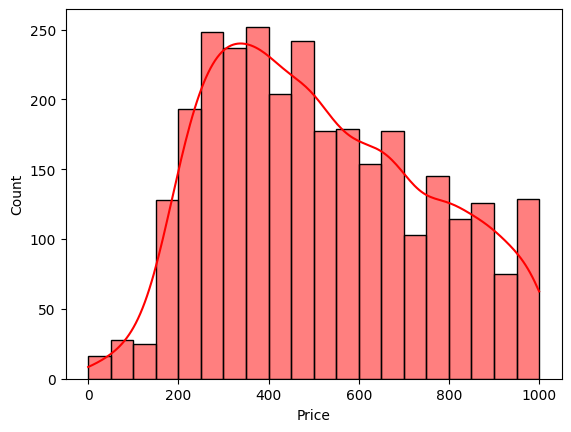

In [42]:
sns.histplot(df["Price"],kde=True,color='red')
plt.show()

In [43]:
def countplot(col):
    plt.figure(figsize=(5,4))
    sns.countplot(data=dfp, x=col, palette="bright")
    plt.xticks(rotation=90)

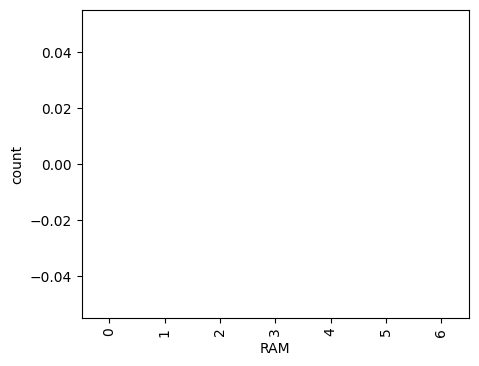

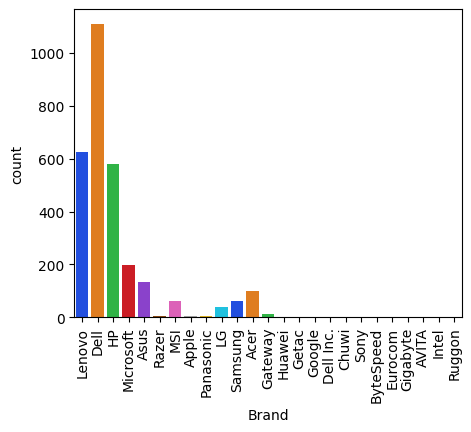

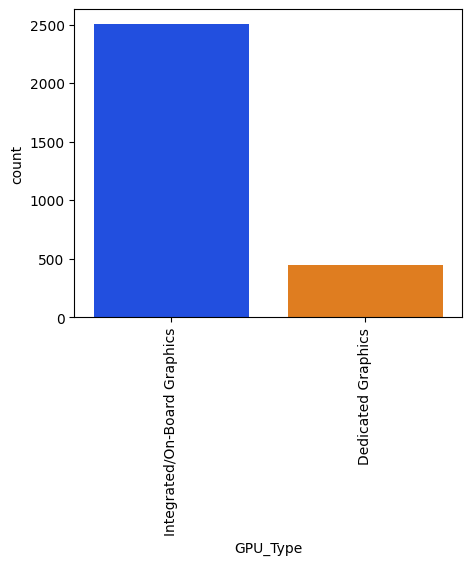

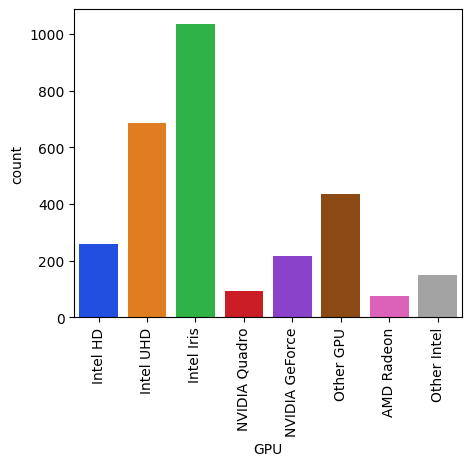

In [44]:
for col in ["RAM","Brand","GPU_Type","GPU"]:
    countplot(col)

In [45]:
def barplot(col):
    sns.barplot(data=dfp, x=col, y="Price", palette="bright")
    plt.xticks(rotation=90)
    plt.show()

In [46]:
cat_cols = dfp.select_dtypes(include="object").columns
num_cols = dfp.select_dtypes(include=["int","float"]).columns

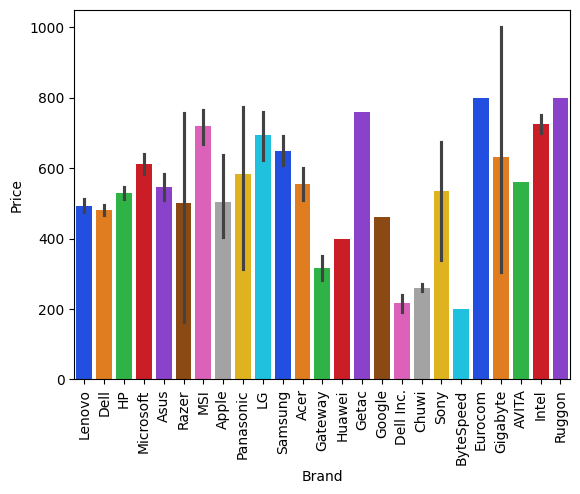

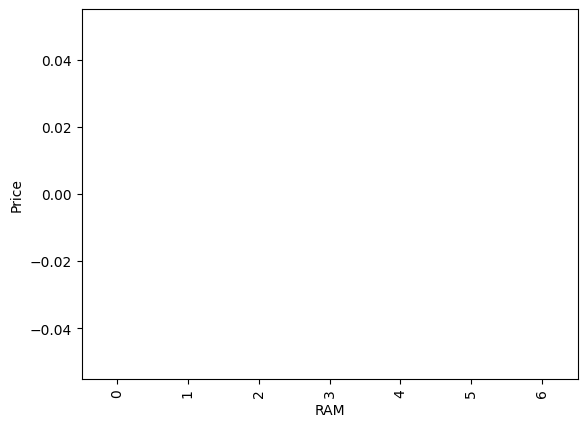

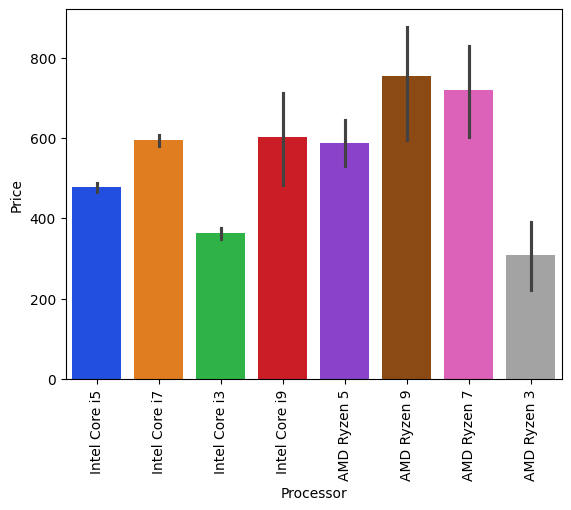

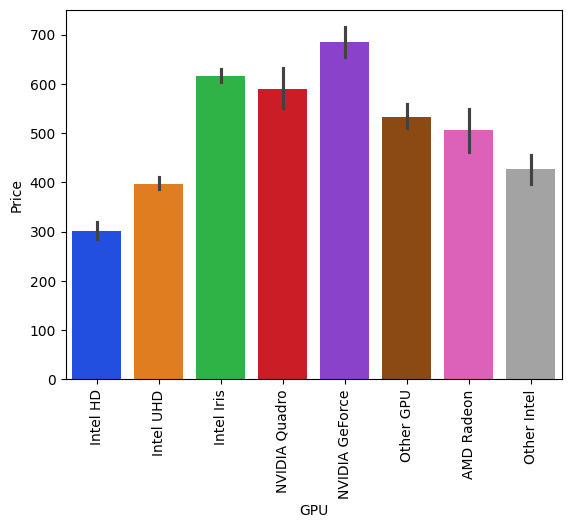

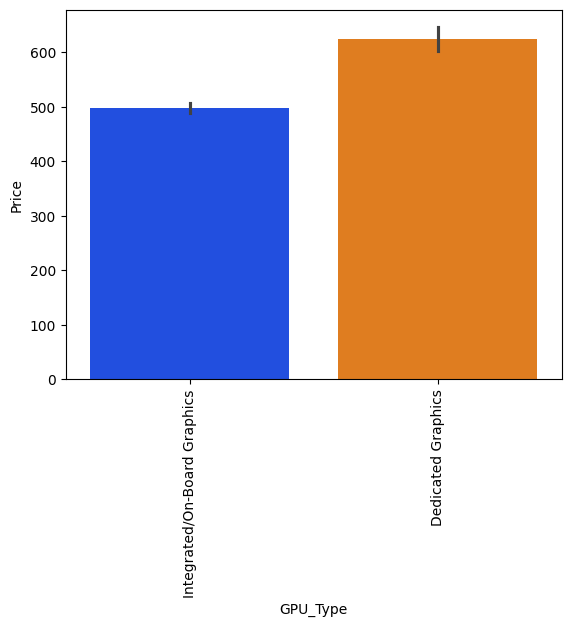

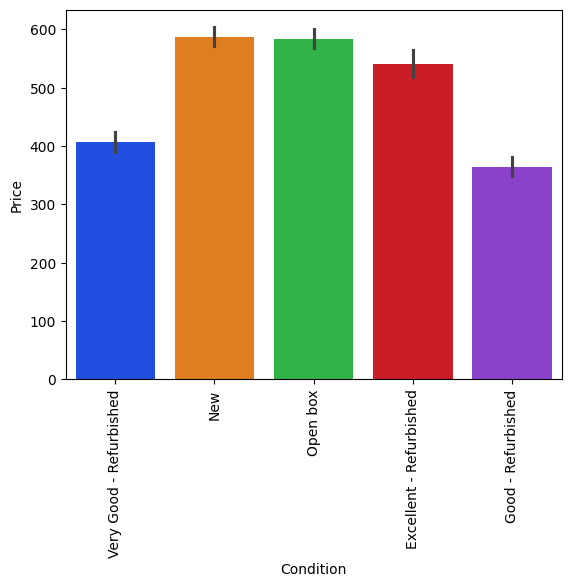

In [47]:
for col in cat_cols:
    barplot(col)

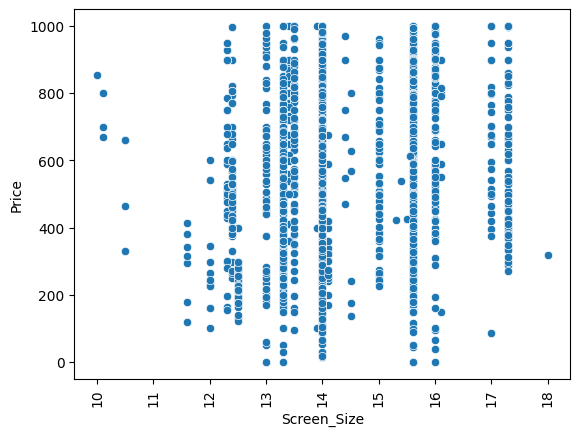

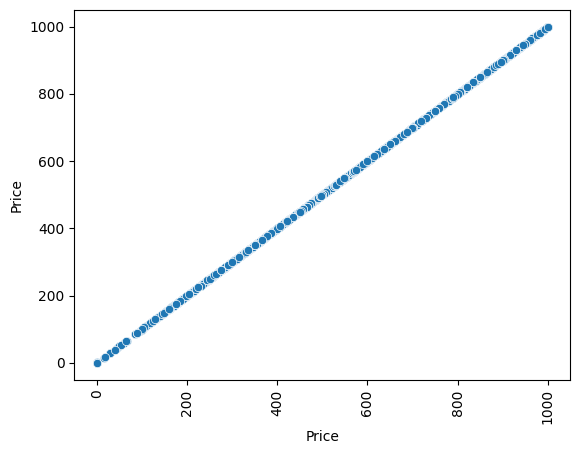

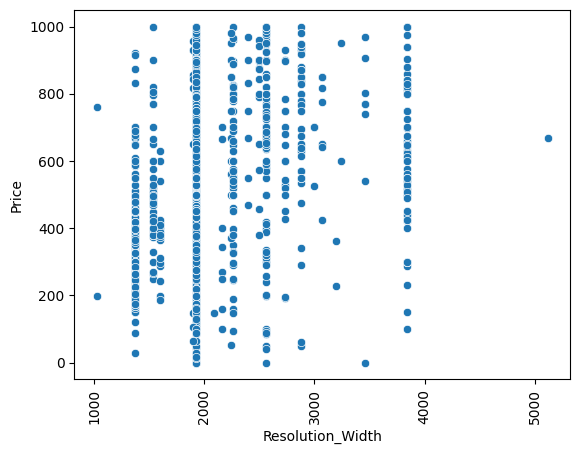

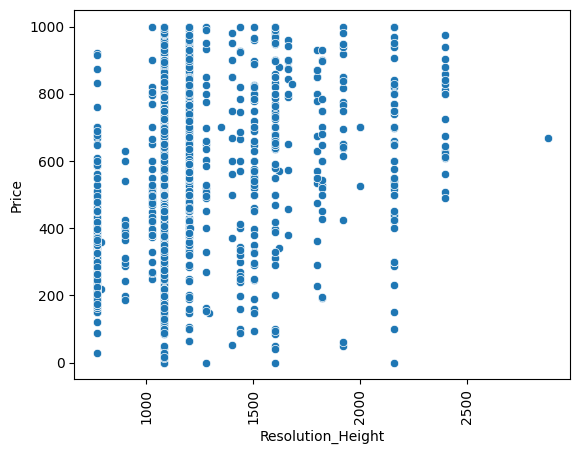

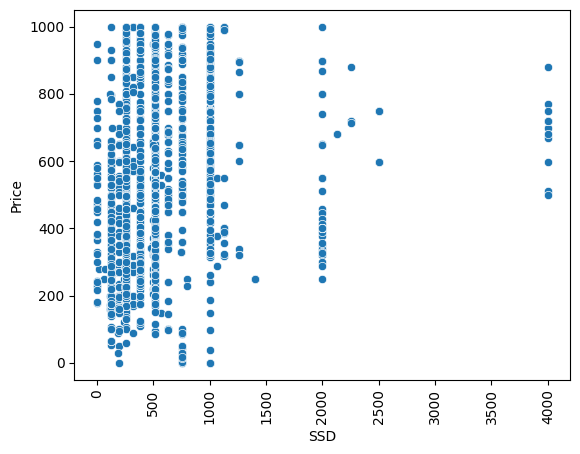

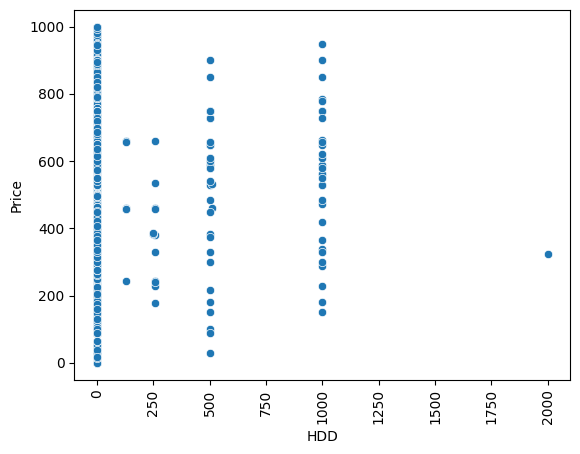

In [48]:
def scatterplot(col):
    sns.scatterplot(data=dfp, x=col, y="Price", palette="bright")
    plt.xticks(rotation=90)
    plt.show()
for col in num_cols:
    scatterplot(col)

In [49]:
brand_counts = dfp['Brand'].value_counts()
less_50_brand = brand_counts[brand_counts < 50].index.tolist()
dfp["Brand"] = np.where(dfp['Brand'].isin(less_50_brand), 'Other', dfp['Brand'])
dfp["Brand"].value_counts()

,count
Brand,
Dell,1109
Lenovo,627
HP,578
Microsoft,197
Asus,134
Acer,100
Other,84
MSI,62
Samsung,61


<Axes: >

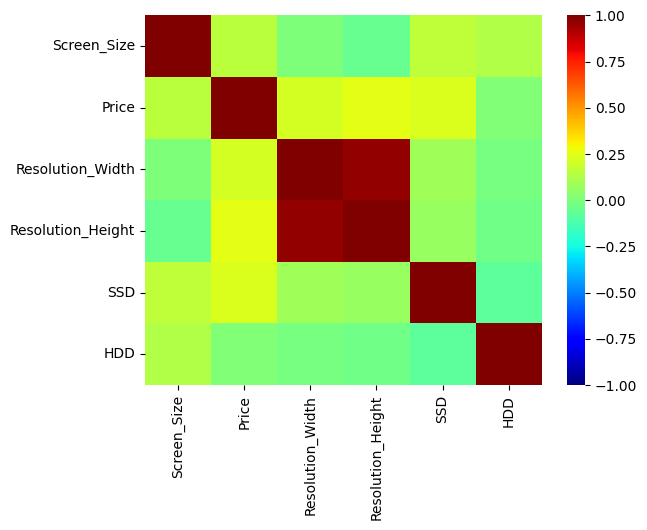

In [50]:
sns.heatmap(dfp[num_cols].corr(),cmap="jet",vmin=-1)

In [51]:
dfp[num_cols].corr()["Price"].sort_values(ascending=False)

,Price
Price,1.000000
Resolution_Height,0.250542
SSD,0.233051
Resolution_Width,0.213576
Screen_Size,0.155904
HDD,0.008442


## 4. Feature Engineering

In [52]:
dfp["PPI"] = np.sqrt(dfp["Resolution_Width"]**2 + dfp["Resolution_Height"]**2)/dfp["Screen_Size"]
dfp.drop(["Resolution_Width","Resolution_Height","Screen_Size"],axis=1,inplace=True)

#### Encoding

In [53]:
dfp["Condition"].unique()

array(['Very Good - Refurbished', 'New', 'Open box',
       'Excellent - Refurbished', 'Good - Refurbished'], dtype=object)

In [54]:
ordinal_enc = OrdinalEncoder(categories=[[
    'New', 'Open box', 'Excellent - Refurbished',
    'Very Good - Refurbished', 'Good - Refurbished'
    ]]).set_output(transform="pandas")
condition_df = ordinal_enc.fit_transform(np.array(dfp["Condition"]).reshape(-1,1)).reset_index(drop=True)
df_encoded = pd.concat([dfp.select_dtypes(include="object").reset_index(drop=True), condition_df], axis=1)
df_encoded.drop("Condition",axis=1,inplace=True)
df_encoded = df_encoded.rename(columns={"x0":"Condition"})

In [55]:
onehot_df = df_encoded.select_dtypes(include="object").reset_index(drop=True)
encoder = OneHotEncoder()
onehot_encoded_df = encoder.fit_transform(onehot_df)
df_encoded = pd.concat([df_encoded, pd.DataFrame(onehot_encoded_df.toarray(), columns=encoder.get_feature_names_out())], axis=1)
df_encoded.drop(df_encoded.select_dtypes(include="object").columns,axis=1,inplace=True)

In [56]:
df_final = pd.concat([dfp.select_dtypes(include=["int","float"]).reset_index(drop=True),df_encoded],axis=1)

#### Train Test Split

In [57]:
y = df_final["Price"]
X = df_final.drop("Price",axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 5. Model Development

In [58]:
# Linear Regression
LR = LinearRegression()
LR.fit(X_train,y_train)
y_pred = LR.predict(X_test)
r2_LR = r2_score(y_test, y_pred)
rmse_LR = np.sqrt(mean_squared_error(y_test, y_pred))
print("Linear Regression")
print(f"R-squared : {r2_LR}\nRMSE\t : {rmse_LR}")

Linear Regression
R-squared : 0.3936875743366143
RMSE	 : 179.00786832622782


In [59]:
# Lasso Regression
LS = Lasso()
LS.fit(X_train,y_train)
y_pred = LS.predict(X_test)
r2_lasso = r2_score(y_test, y_pred)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred))
print("Lasso Regression")
print(f"R-squared : {r2_lasso}\nRMSE\t : {rmse_lasso}")

Lasso Regression
R-squared : 0.38979216711797726
RMSE	 : 179.58198827480953


In [60]:
# Suppor Vector Regression
svr = SVR(C=100, degree=4, gamma="auto")
svr.fit(X_train,y_train)
y_pred = svr.predict(X_test)
r2_svr = r2_score(y_test, y_pred)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred))
print("Support Vector Machine")
print(f"R-squared : {r2_svr}\nRMSE\t : {rmse_svr}")

Support Vector Machine
R-squared : 0.3705830435500116
RMSE	 : 182.38667493888013


In [61]:
# Random Forest Regression
forest = RandomForestRegressor( n_estimators=96, max_depth=19,
                                max_features="log2", min_samples_leaf=2,
                                min_samples_split=8, bootstrap=False,
                                random_state=42)
forest.fit(X_train,y_train) # Train the model
y_pred = forest.predict(X_test) # Predict the dependent variable using trained model
r2_forest = r2_score(y_test, y_pred)
rmse_forest = np.sqrt(mean_squared_error(y_test, y_pred))
print("Random Forest Regression")
print(f"R-squared : {r2_forest}\nRMSE\t : {rmse_forest}")

Random Forest Regression
R-squared : 0.49499364336913676
RMSE	 : 163.3699999509057


In [62]:
# XGBoost Regression
xgboost = XGBRegressor(n_estimators=120, max_depth=5)
xgboost.fit(X_train,y_train)
y_pred = xgboost.predict(X_test)
r2_xgboost = r2_score(y_test, y_pred)
rmse_xgboost = np.sqrt(mean_squared_error(y_test, y_pred))
print("XGBoost Regression")
print(f"R-squared : {r2_xgboost}\nRMSE\t : {rmse_xgboost}")

XGBoost Regression
R-squared : 0.4875466077373465
RMSE	 : 164.57015293726042


In [63]:
r2 = pd.DataFrame({
    "Linear" : float("{:.4f}".format(r2_LR)),
    "SVM": float("{:.4f}".format(r2_LR)),
    "Random Forest" : float("{:.4f}".format(r2_forest)),
    "XGBoost" : float("{:.4f}".format(r2_xgboost))
      },index=range(1))

rmse = pd.DataFrame({
    "Linear" : float("{:.4f}".format(rmse_LR)),
    "SVM": float("{:.4f}".format(rmse_LR)),
    "Random Forest" : float("{:.4f}".format(rmse_forest)),
    "XGBoost" : float("{:.4f}".format(rmse_xgboost))
      },index=range(1))

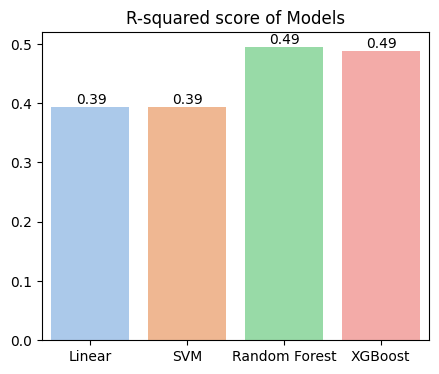

In [64]:
plt.figure(figsize=(5,4))
sns.barplot(data=r2, palette="pastel")
plt.title("R-squared score of Models")
for p in plt.gca().patches:
    plt.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.005))

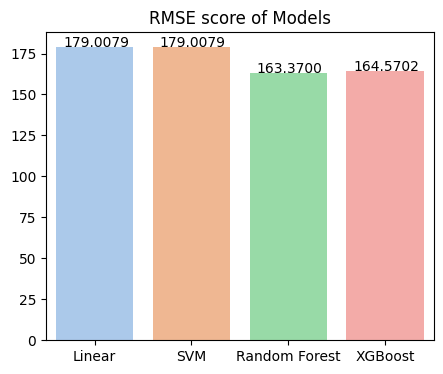

In [65]:
plt.figure(figsize=(5,4))
sns.barplot(data=rmse, palette="pastel")
plt.title("RMSE score of Models")
for p in plt.gca().patches:
    plt.annotate('{:.4f}'.format(p.get_height()), (p.get_x()+0.075, p.get_height()+0.005))

In [66]:
feature_names = X.columns
importances = forest.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.head(10)

,Feature,Importance
3,Condition,0.209591
0,SSD,0.173364
2,PPI,0.116748
24,GPU_Intel Iris,0.064992
23,GPU_Intel HD,0.064011
25,GPU_Intel UHD,0.060583
20,Processor_Intel Core i7,0.048402
18,Processor_Intel Core i3,0.041282
19,Processor_Intel Core i5,0.026666
6,Brand_Dell,0.025210


## 6. Model Deployment

In [67]:
categorical_features = list(set(dfp.select_dtypes(include="object").columns)-set(["Condition"]))
ordinal_features = ["Condition"]
numeric_features = dfp.select_dtypes(include=["int","float"])

ordinal_encoder = OrdinalEncoder(categories=[[
    'New', 'Open box', 'Excellent - Refurbished',
    'Very Good - Refurbished', 'Good - Refurbished'
]])
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', one_hot_encoder, categorical_features),
        ('ordinal', ordinal_encoder, ordinal_features)
    ],
    remainder='passthrough'
)


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=96, max_depth=19,
                                max_features="log2", min_samples_leaf=2,
                                min_samples_split=8, bootstrap=False,
                                random_state=42))
])

In [68]:
X = dfp.drop("Price", axis=1)
y = dfp["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("R-squared : {:.4f}".format(r2_score(y_test,y_pred)))
print("RMSE\t  : {:.4f}".format(np.sqrt(mean_squared_error(y_test,y_pred))))

R-squared : 0.5141
RMSE	  : 156.4177


In [70]:
import pickle
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)